# Recorte dos dados de chuva nos shapefiles das usinas.

In [1]:
import pandas as pd
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import geojson
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
sea.set_style('darkgrid')

In [2]:
cut = gpd.read_file('/home/data/shapes/shapes_smap/MODCLIM4/usinas_MODCLIM4.shp')
cut = cut.set_crs(4326)
cut

,index,Usina,geometry
0,sobradinho,sobradinho,"POLYGON ((-46.17732 -19.37266, -46.17732 -19.1..."
1,0,b_esperanca,"MULTIPOLYGON (((-45.87667 -10.25744, -45.87566..."
2,4,passo_real,"POLYGON ((-52.37063 -28.70584, -52.37256 -28.7..."
3,10,santo_antonio,"MULTIPOLYGON (((-63.86028 -10.48062, -63.86028..."
4,3,tucurui,"POLYGON ((-49.98159 -3.68789, -49.97569 -3.694..."
5,5,sao_simao,"POLYGON ((-48.96839 -17.00000, -48.96962 -17.0..."
6,10,furnas,"MULTIPOLYGON (((-46.33466 -20.55317, -46.33787..."
7,2,g_b_munhoz,"POLYGON ((-51.00201 -25.56806, -51.00203 -25.5..."


In [3]:
us_list = [cut.loc[0], cut.loc[1], cut.loc[2], cut.loc[3],cut.loc[4], cut.loc[5], cut.loc[6], cut.loc[7]]

In [4]:
path_list = ['/home/data/Precip/CPC/precip00_79_20.nc','/home/data/Precip/CPC/precip1_79_20.nc','/home/data/Precip/CPC/precip2_79_20.nc','/home/data/Precip/CPC/precip3_79_20.nc','/home/data/Precip/CPC/precip4_79_20.nc','/home/data/Precip/CPC/precip5_79_20.nc','/home/data/Precip/CPC/precip6_79_20.nc']

precip = xr.open_mfdataset(path_list, concat_dim='time')

#res = conc.resample(time='m').sum()
# ajusta a coordenada da longitude entre -180 e 180 
precip = precip.assign_coords(lon=(((precip.lon + 180) % 360) - 180)).sortby('lon')

/home/gabriel/miniconda3/envs/bloqueios/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [5]:
res = precip.sel(lon=slice(-80,0))

res = res.sel(lat=slice(20,-50))

In [6]:
ends = res.where(res['time.month'] >= 10, drop=True)
begins = res.where(res['time.month'] < 4, drop=True)
CPC = xr.concat([ends, begins], dim='time')

CPC = CPC.sortby(CPC.time)/10
CPC

<xarray.Dataset>
Dimensions:  (lat: 140, lon: 160, time: 7670)
Coordinates:
  * lat      (lat) float32 19.75 19.25 18.75 18.25 ... -48.75 -49.25 -49.75
  * lon      (lon) float32 -79.75 -79.25 -78.75 -78.25 ... -1.25 -0.75 -0.25
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-01-15
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(90, 140, 160), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.0
    version:        V1.0
    history:        created 9/2016 by CAS NOAA/ESRL PSD
    title:          CPC GLOBAL PRCP V1.0
    dataset_title:  CPC GLOBAL PRCP V1.0
    Source:         ftp://ftp.cpc.ncep.noaa.gov/precip/CPC_UNI_PRCP/
    References:     https://www.psl.noaa.gov/data/gridded/data.cpc.globalprec...

In [7]:
def data(shp):
    precip = CPC.resample(time='m').sum()
    
    df = precip.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['lon'],df['lat']))
    gdf = gdf.set_crs(4326)
    
    clipped = gpd.clip(gdf, shp['geometry'])
    clipped = clipped.groupby('time').mean().dropna()
    clipped.to_pickle('/home/github/Climatology/Mod/Files/'+str(shp['Usina'])+'.pkl')
    return clipped

In [8]:
def figura(shp):
    clipped = data(shp)
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,5))
    fig.suptitle(str(shp['Usina']), weight="medium",style="oblique",va="top", ha="center")
    ax.plot(clipped.index, clipped['precip'])
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    plt.savefig('/home/github/Climatology/Mod/Files/'+str(shp['Usina'])+'.png')

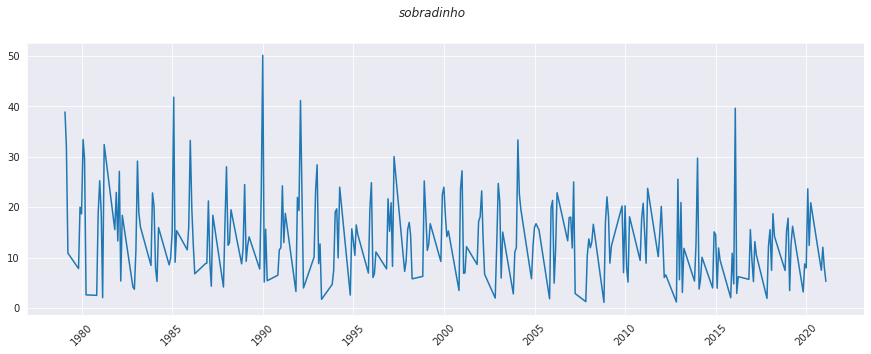

In [30]:
figura(us_list[0])

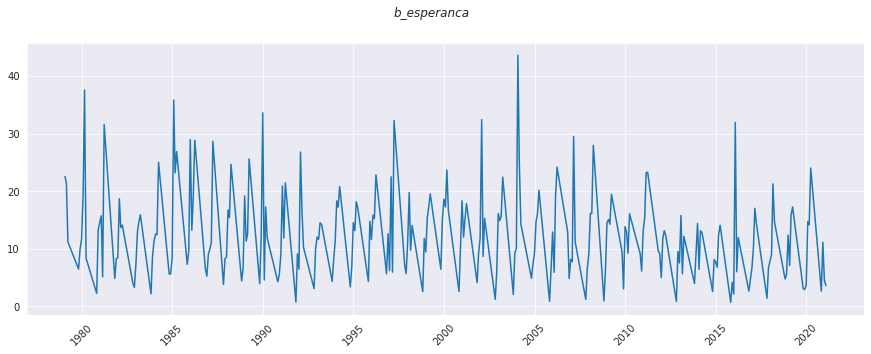

In [9]:
figura(us_list[1])

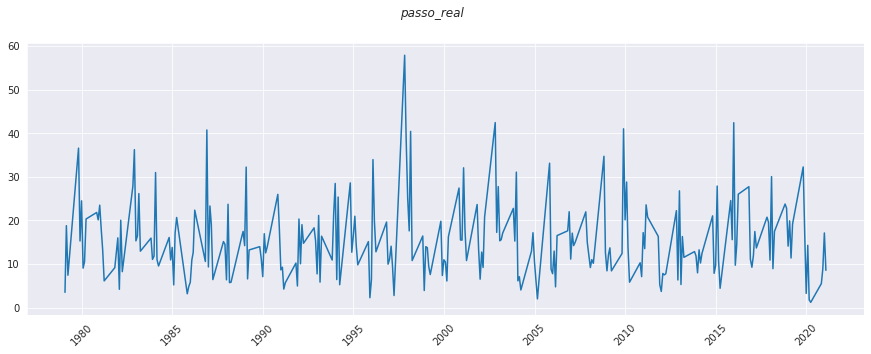

In [10]:
figura(us_list[2])

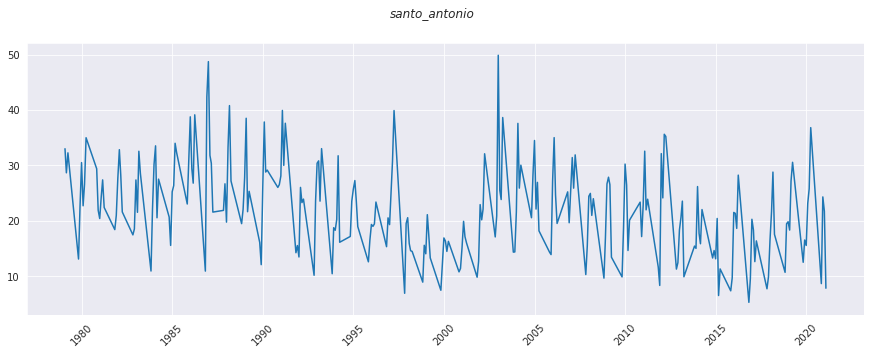

In [11]:
figura(us_list[3])

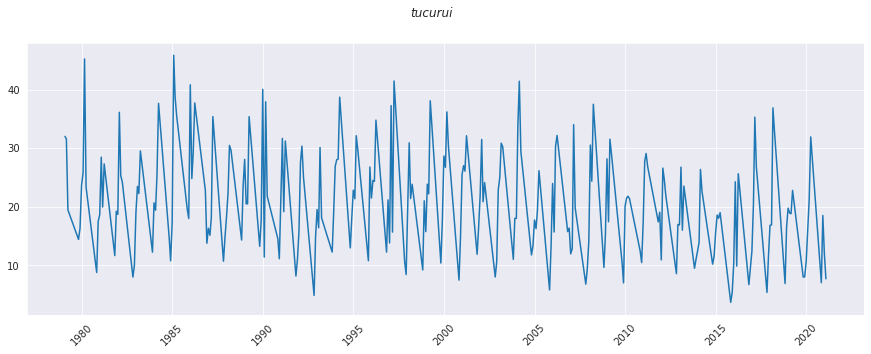

In [12]:
figura(us_list[4])

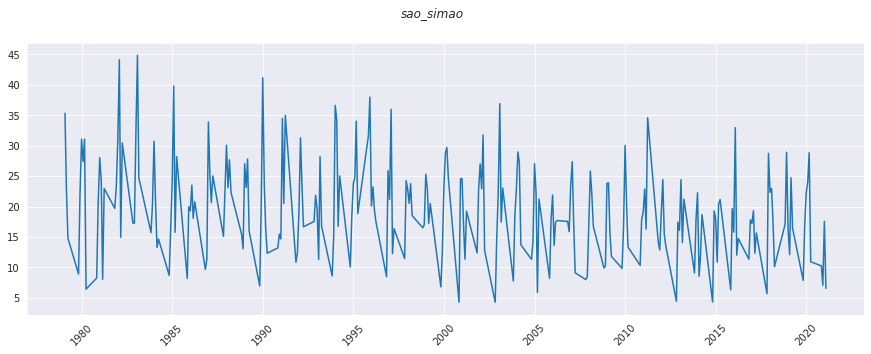

In [13]:
figura(us_list[5])

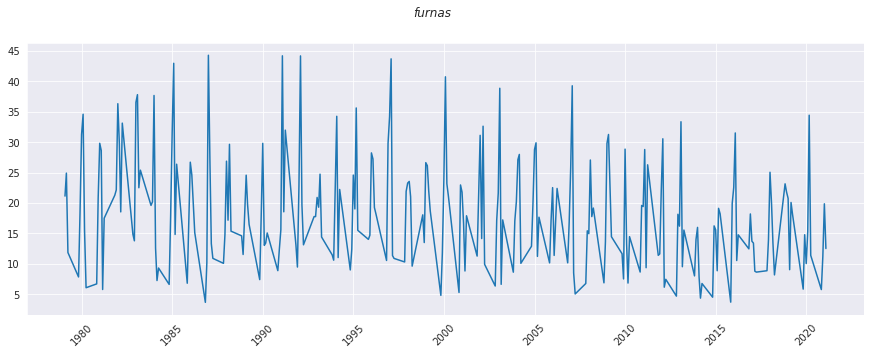

In [14]:
figura(us_list[6])

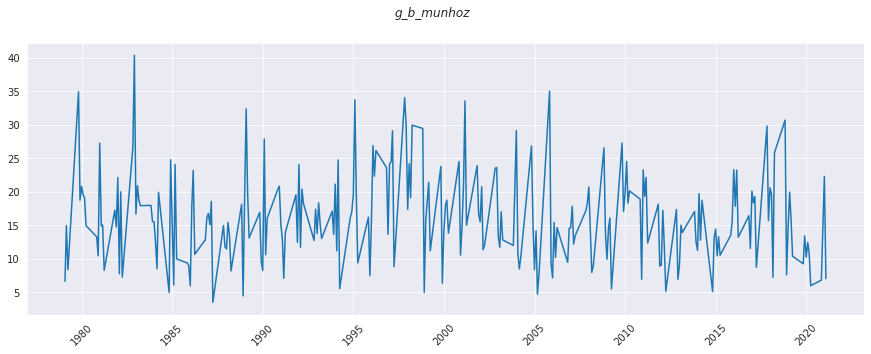

In [9]:
figura(us_list[7])

# Resultados anteriores

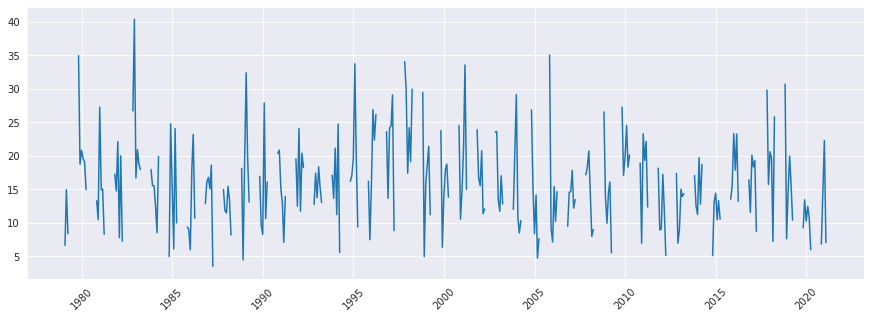

In [22]:
clipped = pd.read_pickle('g_b_munhoz.pkl')
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,5))
#fig.suptitle(str(shp['Usina']), weight="medium",style="oblique",va="top", ha="center")
ax.plot(clipped.index, clipped['precip'])
ax.tick_params(axis='x', labelsize=10, rotation=45)
plt.savefig('/home/github/Climatology/Mod/Files/' + "usin"+'.png')

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(15,5))
fig.suptitle('foz do areia', weight="medium",style="oblique",va="top", ha="center")
ax.plot(group.index, group['precip'])
ax.tick_params(axis='x', labelsize=10, rotation=45)

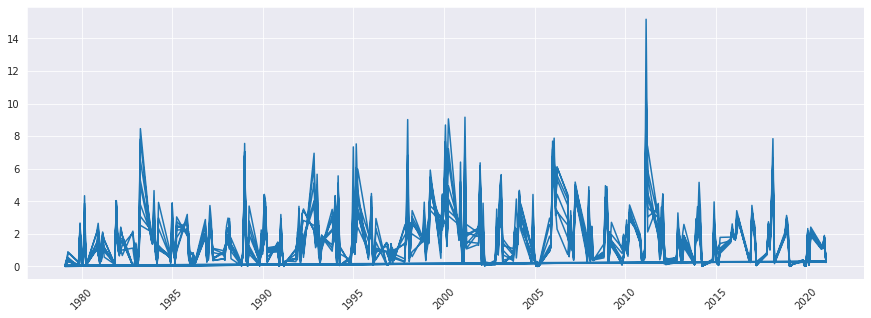

In [32]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Passo Real - Jacui.shp')

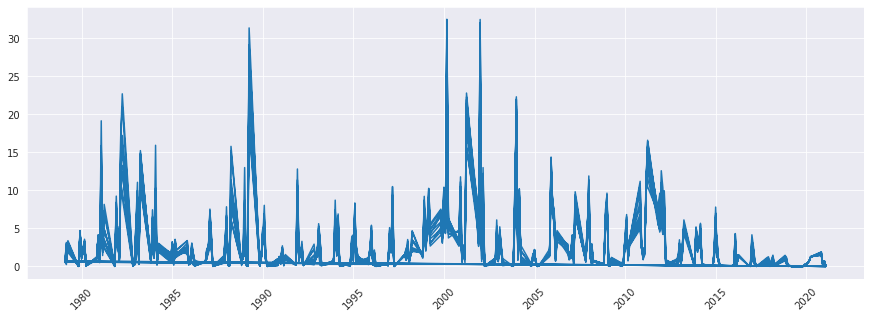

In [33]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Foz do Areia.shp')

In [34]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Boa Esperanca - Parnaiba.shp')

DriverError: /mnt/d/_Gabriel/Data/data/shapes/shapes_smap/MODCLIM/Boa Esperanca - Parnaiba.shp: No such file or directory

In [ ]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Santo Antonio - Madeira.shp')

In [ ]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Sao Simao.shp')

In [ ]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Sobradinho.shp')

In [ ]:
figura('/home/data/shapes/shapes_smap/MODCLIM/Tucurui - Tocantins.shp')

# SHAPEFILE OFICIAL

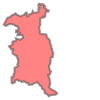

In [107]:
us_list[3]['geometry']

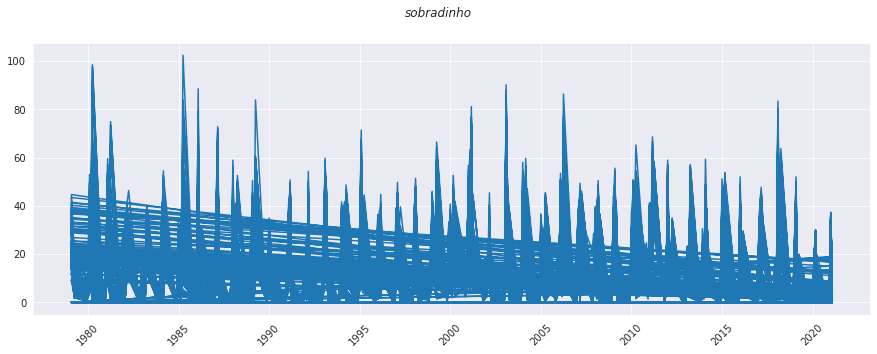

In [111]:
figura(us_list[0])

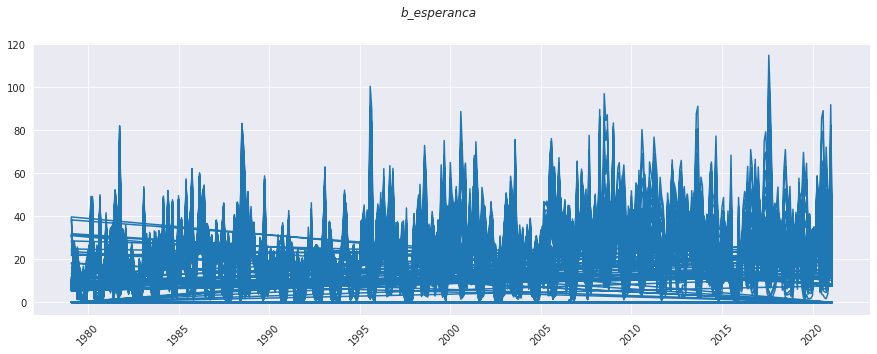

In [113]:
figura(us_list[1])

In [ ]:
figura(us_list[2])

In [ ]:
figura(us_list[3])

In [ ]:
figura(us_list[4])

In [ ]:
figura(us_list[5])

In [ ]:
figura(us_list[6])

In [56]:
shp_list = ['/home/data/shapes/shapes_smap/MODCLIM/Furnas.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Passo Real - Jacui.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Foz do Areia.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Boa Esperanca - Parnaiba.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Santo Antonio - Madeira.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Sao Simao.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Sobradinho.shp',
'/home/data/shapes/shapes_smap/MODCLIM/Tucurui - Tocantins.shp']